# Building other classification models

This notebook aims to build other classification model than the XGBoost model. However, it still uses the same methods and cleaning processes.

In [7]:
#Essential modules
import pandas as pd
import numpy as np

#For text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#For model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

#Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#For word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yanis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df = pd.read_csv("events.csv")
to_drop = ['sort_order', 'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break']
df.drop(to_drop, axis=1)
print("Number of games in the dataset :", len(df["id_odsp"].unique()))
print("Number of text commentary in the dataset:", len(df))

Number of games in the dataset : 9074
Number of text commentary in the dataset: 941009


In [9]:
num_to_cat = {1:"Attempt", 
2:"Corner",
3:"Foul", 
4:"Yellow card", 
5:"Second yellow card", 
6:"Red card",
7:"Substitution", 
8:"Free kick won", 
9:"Offside", 
10:"Hand ball", 
11:"Penalty conceded"
}

In [10]:
df_train = df[["text", "event_type"]]
df_train = df_train[:10000]
df_train.isna().sum()

text          0
event_type    0
dtype: int64

In [11]:
#Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [12]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
df_train['clean_text'] = df_train['text'].progress_apply(lambda x: finalpreprocess(x))
df_train.head()

C:\Users\yanis\AppData\Local\Temp/ipykernel_8316/2891757286.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,text,event_type,clean_text
0,Attempt missed. Mladen Petric (Hamburg) left f...,1,attempt miss mladen petric hamburg leave foot ...
1,"Corner, Borussia Dortmund. Conceded by Dennis...",2,corner borussia dortmund concede dennis diekmeier
2,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,corner borussia dortmund concede heiko westermann
3,Foul by Sven Bender (Borussia Dortmund).,3,foul sven bender borussia dortmund
4,Gokhan Tore (Hamburg) wins a free kick in the ...,8,gokhan tear hamburg win free kick defensive half


In [13]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["event_type"],test_size=0.2,shuffle=True, random_state=42)

In [14]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [15]:
import pickle
with open('tfidf.pkl', 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)

In [16]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

models = [SVC(kernel='poly',  probability=True), MLPClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
n=0
for model in models:
    textclassifier = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('smote', SMOTE(random_state=42)),
            ('xgb', model)
            ])
    textclassifier.fit(X_train, y_train)
    #Save the model in a compressed pickle file
    import pickle 
    pickle.dump(textclassifier , open(f"pipeline_{n}.pickle", "wb"))
    n+=1

In [132]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#clf = SVC(kernel='poly',  probability=True)
#clf = MLPClassifier()
#clf = KNeighborsClassifier()
#clf = DecisionTreeClassifier()
#clf = RandomForestClassifier()
clf = AdaBoostClassifier()


In [133]:
clf.fit(X_train_vectors_tfidf, y_train)

AdaBoostClassifier()

In [134]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
# make predictions for test data
y_pred = clf.predict(X_test_vectors_tfidf)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision:", np.mean(precision_score(y_test, predictions, average=None)))
print("Recall:", np.mean(recall_score(y_test, predictions, average=None)))
print("F1 score:", np.mean(f1_score(y_test, predictions, average=None)))

Accuracy: 61.67%
Precision: 0.3399874745576953
Recall: 0.4
F1 score: 0.3571300749356895


c:\Users\yanis\OneDrive\PC HP SPECTRE 2019\Documents\NLP Project\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
clf.predict(X_test_vectors_tfidf[0])

array([8], dtype=int64)

<AxesSubplot:>

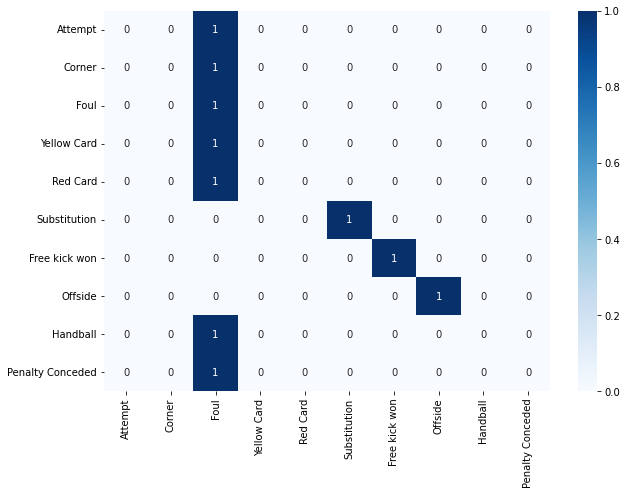

In [136]:
from sklearn.metrics import confusion_matrix
labels = ["Attempt", "Corner", "Foul", "Yellow Card", "Red Card", "Substitution", "Free kick won", "Offside", "Handball", "Penalty Conceded"]
cm = confusion_matrix(y_test,predictions) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
import seaborn as sn
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')